### 数据加载与探索

样本数: 360 特征数: 64
标签分布:
 1    182
0    178
Name: count, dtype: int64


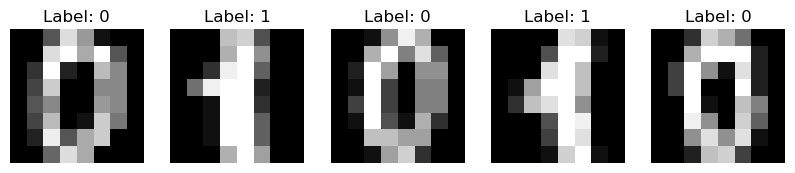

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 加载数据集（只保留数字0和1）
digits = load_digits()
mask = (digits.target == 0) | (digits.target == 1) # 只讨论0和1的部分,mask 是 一个布尔数组（形状与 digits.target 相同）
X = digits.data[mask] # 这一步转换后特征数量不变但样本数减少，利用了mask筛选
y = digits.target[mask] 

# 查看数据基本信息
print("样本数:", X.shape[0], "特征数:", X.shape[1])
print("标签分布:\n", pd.Series(y).value_counts())

# 可视化前5张图像
plt.figure(figsize=(10, 3)) # 画布大小可以自己试
for i in range(5):
    plt.subplot(1, 5, i + 1) # 记得加一，子图标号必须从1开始
    plt.imshow(X[i].reshape(8, 8), cmap='gray') # 显示8 * 8的灰度图
    plt.title(f"Label: {y[i]}")
    plt.axis('off') # 关闭坐标轴
plt.show()

### 数据预处理

In [19]:
# 划分数据集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# 标准化特征（SVM对特征尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("训练集维度:", X_train_scaled.shape)
print("测试机维度:", X_test_scaled.shape)

训练集维度: (288, 64)
测试机维度: (72, 64)


### 手动实现线性SVM

In [20]:
class LinearSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate # 学习率
        self.lambda_param = lambda_param # 正则化系数
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # 将标签转换为-1， 1，svm计算超平面时用特征(-1,1),而不是(0, 1)
        y_ = np.where(y <= 0, -1, 1) # numpy条件筛选函数，满足取-1，否则取1
        
        # 初始化参数
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # 梯度下降优化
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    # 铰链损失函数 = 0，正确分类且间隔足够大
                    # 样本在间隔外， 只需更新权重（正则化项），w = w - lr * (2*lambda*w)
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    # 样本在间隔内或误分类，更新权重和偏置
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y_[idx]))
                    self.bias -= self.lr * y_[idx]
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights) - self.bias
        return np.sign(linear_output) # 返回预测类别（-1或1）
    
# 训练手动实现模型
manual_model = LinearSVM(learning_rate=0.01, lambda_param=0.01, n_iters=1000)
manual_model.fit(X_train_scaled, y_train)

# 预测测试集（将-1映射回0）
y_pred_manual = manual_model.predict(X_test_scaled)
y_pred_manual = np.where(y_pred_manual == -1, 0, 1)


        

### sklearn实现

In [24]:
# 创建并训练线性核SVM
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train_scaled, y_train)

# 创建并训练RBF核SVM（非线性）
rbf_svm = SVC(kernel='rbf', gamma=0.1, C=1.0) # 多一个gamma参数
rbf_svm.fit(X_train, y_train) # 注意rbf核不需要归一化

# 预测测试集
y_pred_linear = linear_svm.predict(X_test_scaled)
y_pred_rbf = rbf_svm.predict(X_test_scaled)

### 模型评估与可视化


[手动实现线性SVM] 准确率: 1.000
[手动实现线性SVM] 混淆矩阵:
 [[35  0]
 [ 0 37]]
[手动实现线性SVM] 分类报告:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        37

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72


[Sklearn线性SVM] 准确率: 1.000
[Sklearn线性SVM] 混淆矩阵:
 [[35  0]
 [ 0 37]]
[Sklearn线性SVM] 分类报告:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        37

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72


[Sklearn RBF核SVM] 准确率: 0.514
[Sklearn RBF核SVM] 混淆矩阵:
 [[ 0 35]
 [ 0 37]]
[Sklearn RBF核SVM] 分类报告:
               precision    recall  f1-score   support

           0       0.

D:\anaconda\envs\rurie\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\envs\rurie\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\envs\rurie\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\envs\rurie\Lib\site-packages\IPyth

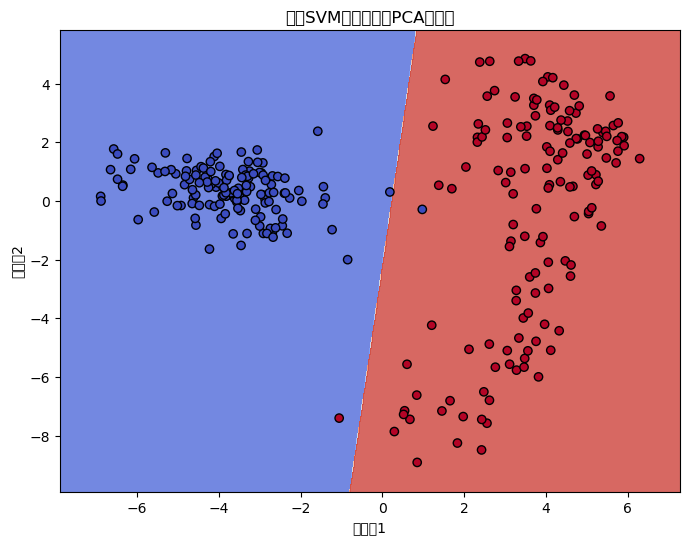

In [26]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    print(f"\n[{model_name}] 准确率: {acc:.3f}")
    print(f"[{model_name}] 混淆矩阵:\n", cm)
    print(f"[{model_name}] 分类报告:\n", report)

# 对比三个模型
evaluate_model(y_test, y_pred_manual, "手动实现线性SVM")
evaluate_model(y_test, y_pred_linear, "Sklearn线性SVM")
evaluate_model(y_test, y_pred_rbf, "Sklearn RBF核SVM")

# 可视化决策边界（仅用于二维特征，此处使用PCA降维）
from sklearn.decomposition import PCA

# 使用主成分分析将数据降至二维，便于展示可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# 训练线性SVM用于可视化
svm_for_plot = SVC(kernel='linear')
svm_for_plot.fit(X_pca, y_train)

# 创建网格点
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), 
                    np.arange(y_min, y_max, 0.02))

# 预测网格点类别
Z = svm_for_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 绘制决策边界
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm) 
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel('主成分1')
plt.ylabel('主成分2')
plt.title('线性SVM决策边界（PCA降维）')
plt.show()